## Model Pix2Pix to Reconstruction Images

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt


#### Load the dataset

In [26]:
# Load ground truth image to use
ground_truh_path = '../assets/ground_truth_image'

tif_path = os.path.join(ground_truh_path, 'ground_truth_images.tif')
tif_image = Image.open(tif_path)

def load_tif_image(tif, index):
    tif.seek(index)
    return np.array(tif)

def extract_first_subimage(image):
    return image[:, :256, :]

idx = [11,31,71,91,111,131,151,171,20]
ground_truh_images = [extract_first_subimage(load_tif_image(tif_image, i)) for i in idx]
ground_truh_images = np.array(ground_truh_images)

print('Size of the ground truth images:', ground_truh_images.shape)


Size of the ground truth images: (9, 256, 256, 3)


In [27]:
# Load curtained image to use
curtained_path = '../assets/curtained_image'

curtained_images = []
for file_name in os.listdir(curtained_path):
    if file_name.endswith('.png'):
        img_path = os.path.join(curtained_path, file_name)
        image = np.array(Image.open(img_path))
        first_subimage = extract_first_subimage(image)
        if first_subimage.shape == (256, 256, 3):
            curtained_images.append(first_subimage)
        else:
            print(f"Imagen {file_name} tiene un tamaño inesperado: {first_subimage.shape}")

curtained_images = np.array(curtained_images)
print('Size of the curtained images:', curtained_images.shape)


Size of the curtained images: (9, 256, 256, 3)


In [28]:
def load(input_image, target_image):
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
    target_image = tf.convert_to_tensor(target_image, dtype=tf.float32)

    return input_image, target_image

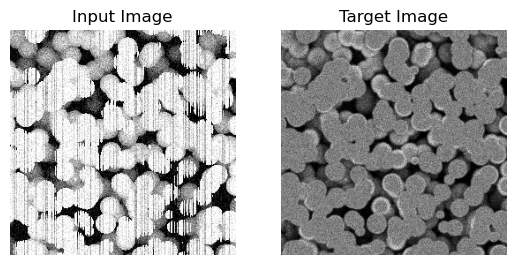

In [29]:
sample_curtained = curtained_images[0]
sample_ground_truth = ground_truh_images[0]

input_image, target_image = load(sample_curtained, sample_ground_truth)

plt.subplot(121)
plt.imshow(input_image/255.0)
plt.axis('off')
plt.title('Input Image')

plt.subplot(122)
plt.imshow(target_image/255.0)
plt.axis('off')
plt.title('Target Image')

plt.show()

In [30]:
# The facade training set consist of 400 images
BUFFER_SIZE = 10
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

#### Random jittering and mirroring to preprocess the training set

In [31]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [32]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [33]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [34]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

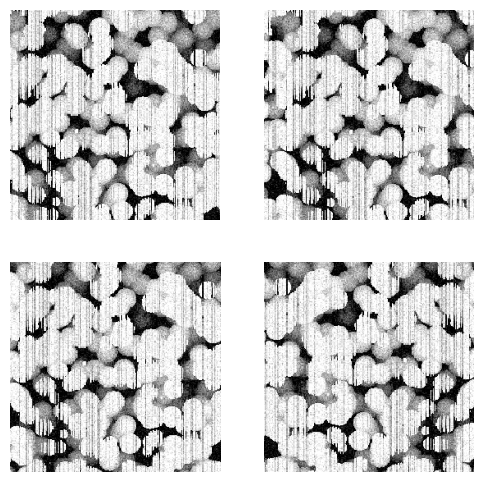

In [35]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_input_image, rj_target_image = random_jitter(input_image, target_image)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_input_image/255.0)
    plt.axis('off')
plt.show()